In [24]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras import layers
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity

### Load test set

In [6]:
dataset = "mnistlikedataset128x1.npz"

with np.load(dataset) as data:
    #load DataX as train_data
    data = data['DataX']
    np.random.shuffle(data)
    portion = int(0.8*len(data))
    x_train, x_test = data[:portion,:], data[portion:,:]
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))
    x_test = np.reshape(x_test, (len(x_test), 128, 128, 1))
    print(x_train.shape)
    print(x_test.shape)

autoencoder_path = 'conv_autoencoder.keras'
autoencoder = keras.models.load_model(autoencoder_path)
decoded_imgs = autoencoder.predict(x_test)

(920, 128, 128, 1)
(230, 128, 128, 1)
8/8 [==============================] - 1s 144ms/step


### Autoencoder Image Reconstruction
<br> This section demonstrates the model is well-performed on test set. The reconstructed images look similar to the original ones.

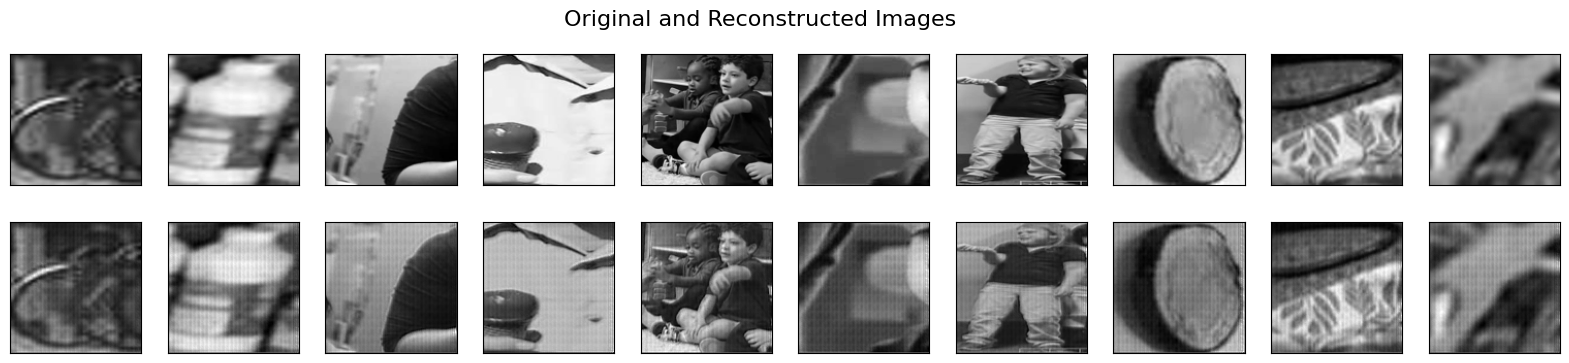

In [7]:
# De
n = 10
plt.figure(figsize=(20, 4))
plt.suptitle('Original and Reconstructed Images', fontsize=16) 
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Use autoencoder to get image embeddings

In [8]:
autoencoder_path = 'conv_autoencoder.keras'
autoencoder = keras.models.load_model(autoencoder_path)
encoder = autoencoder.layers[1]  # Get encoder part

In [3]:
# Load image array data from .npz file
img_arr = "mnistlikedataset128x1.npz"
with np.load(img_arr) as data:
    images = data['DataX']

# Load ROI_data.csv file to get image IDs
roi_data_file = "ROI_data.csv"
roi_data = pd.read_csv(roi_data_file)
image_ids = roi_data['frameID']

# Load trained autoencoder model
autoencoder_path = 'conv_autoencoder.keras'
autoencoder = keras.models.load_model(autoencoder_path)
encoder = autoencoder.layers[1]  # Get encoder part

# Get embeddings for all images
embeddings = encoder.predict(images)


36/36 [==============================] - 7s 4ms/step
1150


In [4]:
print(embeddings.shape)

(1150, 64, 64, 128)


In [14]:
# Flatten the embeddings
flattened_embeddings = embeddings.reshape(embeddings.shape[0], -1)
print(flattened_embeddings.shape)

# Normalize the embeddings
normalized_embeddings = flattened_embeddings / np.linalg.norm(flattened_embeddings, axis=1)[:, np.newaxis]

(1150, 524288)


### Visualize similarity search results
<br> - This section perform cosine similarity search using the first embedding in the ouput array.
<br> - Obtain the image directory to plot using its videoID and frameID.

In [23]:
roi_csv = 'ROI_data.csv'

def similarity_search(query_embedding, normalized_embeddings, top_k=5):
    # Normalize the query embedding
    query_embedding = query_embedding.flatten() / np.linalg.norm(query_embedding)
    
    # Compute cosine similarity between query embedding and all other embeddings
    similarities = cosine_similarity(query_embedding.reshape(1, -1), normalized_embeddings)
    
    # Get indices of top-k most similar embeddings
    top_indices = similarities.argsort()[0][-top_k:][::-1]
    
    return top_indices

def get_image_info(top_indices, roi_csv):
    """Use the top indices to select rows from the DataFrame"""
    df = pd.read_csv(roi_csv)
    video_id = df['videoID'][top_indices+1]
    image_id = df['frameID'][top_indices+1]
    return video_id, image_id

# ---------------------------------------------------------------------
query_index = 0  # Index of the query embedding
query_embedding = normalized_embeddings[query_index]

# Perform similarity search based on the query embedding
top_indices = similarity_search(query_embedding, normalized_embeddings)

img_info = {}
for idx in top_indices:
    video_id, image_id = get_image_info(idx, roi_csv)
    img_info[idx] = {'video_id': video_id, 'image_id': image_id}


print("----------------------------------------")
print("COSINE SIMILARITY SEARCH RESULTS")
print()
print("Top indices:", top_indices)
for idx, info in img_info.items():
    print(f"Index: {idx}")
    print(f"Video IDs: {info['video_id']}")
    print(f"Image IDs: {info['image_id']}")
    print()
print("----------------------------------------")

----------------------------------------
COSINE SIMILARITY SEARCH RESULTS

Top indices: [   0 1073  202  171  167]
Index: 0
Video IDs: VID001
Image IDs: 001_115

Index: 1073
Video IDs: VID003
Image IDs: 003_230

Index: 202
Video IDs: VID002
Image IDs: 002_1265

Index: 171
Video IDs: VID002
Image IDs: 002_1265

Index: 167
Video IDs: VID002
Image IDs: 002_1150

----------------------------------------


DATASET-FRAMES\VID001\001_115.jpg


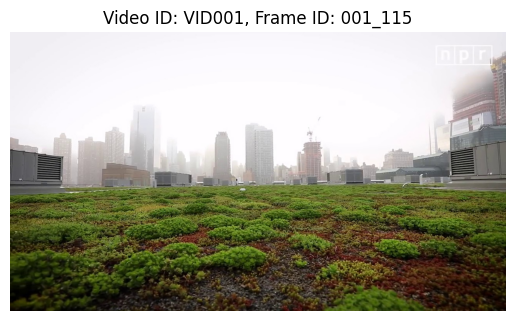

DATASET-FRAMES\VID003\003_230.jpg


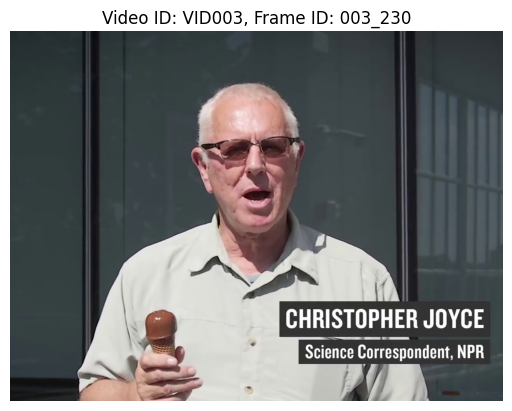

DATASET-FRAMES\VID002\002_1265.jpg


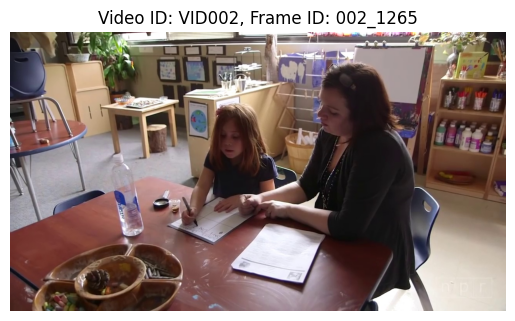

DATASET-FRAMES\VID002\002_1265.jpg


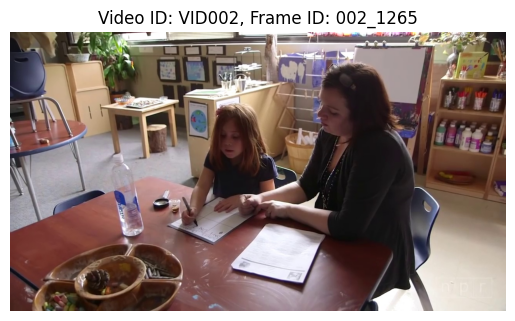

DATASET-FRAMES\VID002\002_1150.jpg


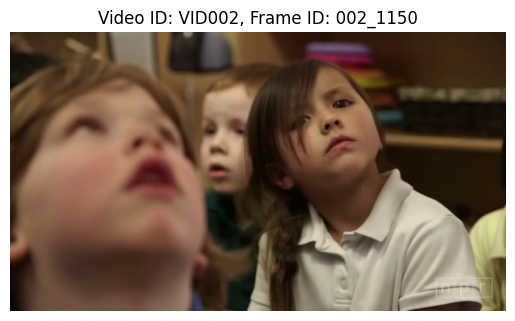

In [34]:
root_dir = 'DATASET-FRAMES'

for idx, info in img_info.items():
    video_id = info['video_ids']
    image_id = info['image_ids']

    img_path = os.path.join(root_dir, f"{video_id}\{image_id}.jpg")
    print(img_path)
    # Check if the image path exists
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Video ID: {video_id}, Frame ID: {image_id}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image not found at path: {img_path}")